In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
import tensorflow as tf
from tensorflow.keras import layers
import time
from typing import Tuple

In [3]:
class GAN:
    def __init__(self):
        self.latent_dim = 10
        self.generator_vector_size = 8
        self.discriminator_input_shape = (self.generator_vector_size,)
        self.num_examples_to_generate = 16

        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()
        self.gan = self.combime_gan(self.generator, self.discriminator)

    def combime_gan(self, g_model, d_model):
        # make weights in the discriminator not trainable
        d_model.trainable = False
        # connect generator and discriminator
        model = tf.keras.Sequential()
        model.add(g_model)
        model.add(d_model)
        opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model

    def make_generator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(30, use_bias=True, input_dim=self.latent_dim))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(15))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        model.add(layers.Dense(self.generator_vector_size, activation='tanh'))

        model.summary()
        return model

        # noise = tf.keras.layers.Input(shape=(self.latent_dim,))
        # g_rows = model(noise)
        # return tf.keras.Model(noise, g_rows)
        # return model

    def make_discriminator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(32, use_bias=True, input_shape=self.discriminator_input_shape))
        # model.add(layers.Dense(32, use_bias=False, input_shape=(8,)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.2))

        model.add(layers.Dense(16))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.2))

        model.add(layers.Flatten())
        model.add(layers.Dense(1, activation='sigmoid'))
        opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        model.summary()
        return model

        # g_rows = tf.keras.layers.Input(shape=self.discriminator_input_shape)
        # validity = model(g_rows)
        # return tf.keras.Model(g_rows, validity)


    def generate_real_x_y(self, data: np.ndarray, n_samples: int) -> Tuple[np.ndarray, np.ndarray]:
        y_real = np.ones((n_samples, 1))
        idx = np.random.randint(0, data.shape[0], n_samples)
        x_real = data[idx]
        return x_real, y_real

    def generate_fake_x_y(self, n_samples: int) -> Tuple[np.ndarray, np.ndarray]:
        y_fake = np.zeros((n_samples, 1))
        # noise = np.random.normal(0, 1, (n_samples, self.latent_dim))
        noise = np.random.uniform(-1, 1, size=(n_samples, self.latent_dim))
        x_fake = self.generator.predict(noise)
        return x_fake, y_fake

    def train(self, df, epochs, batch_size=8):
        # (X_train, _), (_, _) = mnist.load_data()
        # X_train = X_train / 127.5 - 1.
        # X_train = np.expand_dims(X_train, axis=3)
        X_train = df.values
        valid = np.ones((batch_size, 1))
        valid_twice = np.ones((batch_size * 2, 1))
        fake = np.zeros((batch_size, 1))
        d_losses = np.zeros((epochs, 1))
        d_accuracies = np.zeros((epochs, 1))
        d_fake_losses = np.zeros((epochs, 1))
        d_fake_accuracies = np.zeros((epochs, 1))
        d_real_losses = np.zeros((epochs, 1))
        d_real_accuracies = np.zeros((epochs, 1))
        g_losses = np.zeros((epochs, 1))
        g_accuracies = np.zeros((epochs, 1))

        for i, epoch in enumerate(range(epochs)):
            # prepare real fake examples
            x_fake, y_fake = self.generate_fake_x_y(batch_size)
            x_real, y_real = self.generate_real_x_y(X_train, batch_size)
            # create training set for the discriminator
            x, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, d_acc = self.discriminator.train_on_batch(x, y)

            # evaluate discriminator on real examples
            x_real, y_real = self.generate_real_x_y(X_train, batch_size)
            d_loss_real, d_acc_real = self.discriminator.evaluate(x_real, y_real, verbose=0)
            # evaluate discriminator on fake examples
            x_fake, y_fake = self.generate_fake_x_y(batch_size)
            d_loss_fake, d_acc_fake = self.discriminator.evaluate(x_fake, y_fake, verbose=0)

            d_fake_losses[i] = d_loss_fake
            d_real_losses[i] = d_loss_real
            d_fake_accuracies[i] = d_acc_fake
            d_real_accuracies[i] = d_acc_real

            # noise = np.random.normal(0, 1, (batch_size * 2, self.latent_dim))
            noise = np.random.uniform(-1, 1, size=(batch_size * 2, self.latent_dim))
            # create inverted labels for the fake samples so generator can improve to be 'real'
            # update the generator via the discriminator's error
            g_loss, g_acc = self.gan.train_on_batch(noise, valid_twice)

            d_losses[i] = d_loss
            d_accuracies[i] = d_acc
            g_losses[i] = g_loss
            g_accuracies[i] = g_acc
            # if i % 50 == 0:
            #   print("epoch %d [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, d_loss, 100 * d_acc, g_loss, g_acc))
            #   if 800<=i and i<= 1200:
            #     filename = 'generator_model_%03d.h5' % (epoch + 1)
            #     self.generator.save(filename)

            if i % 50 == 0:
                print("epoch %d [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, d_loss, 100 * d_acc, g_loss, g_acc))
                if 800 <= i:
                    if abs(g_loss - d_loss) < 0.2: # check that losses converged
                        if abs(d_acc - 0.5) < 0.2 and abs( d_acc_fake - d_acc_real) < 0.2 : # save generator model for closest to 0.5 accuracy
                            # filename = 'generator_model.h5'
                            filename = f'g_model_{epoch:.2f}_{g_loss:.2f}_{g_loss-d_loss:.2f}_{d_acc:.2f}_{d_acc_fake - d_acc_real:.2f}.h5' 

                            self.generator.save(filename)
                            best_epoch = epoch                   
        return d_losses, d_accuracies, g_losses, g_accuracies, d_fake_losses, d_real_losses, d_fake_accuracies, d_real_accuracies

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
diab_arf = arff.loadarff('gdrive/MyDrive/DL/Assignment_4/diabetes.arff')

In [6]:
diab_df = pd.DataFrame(diab_arf[0])

In [7]:
# diab_df.replace(to_replace=b'tested_negative', value=-1, inplace=True)
# diab_df.replace(to_replace=b'tested_positive', value=1, inplace=True)

In [8]:
diab_df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'tested_positive'


In [9]:
# the values must be scaled to the range [-1,1] to match the output of the generator model
def scaler(df):
  for column in df:
    max = df[column].max()
    min = df[column].min()
    col = 2*((df[column] - min)/(max - min)) - 1
    df[column] = col
  return df

In [10]:
# class is not part of sample description
del diab_df['class']
diab_df = scaler(diab_df)

In [11]:
diab_df.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,-0.547641,0.215020,0.132877,-0.585122,-0.811349,-0.046421,-0.663641,-0.591970
std,0.396421,0.321333,0.317308,0.322267,0.272444,0.234997,0.282945,0.392008
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.882353,-0.005025,0.016393,-1.000000,-1.000000,-0.186289,-0.858454,-0.900000
50%,-0.647059,0.175879,0.180328,-0.535354,-0.927896,-0.046200,-0.748506,-0.733333
75%,-0.294118,0.409548,0.311475,-0.353535,-0.699173,0.090909,-0.531810,-0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
gan = GAN()
# from tensorflow.python.keras.utils.vis_utils import plot_model
# plot_model(gan.generator, to_file='g_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                330       
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
_________________________________________________________________
batch_normalization_1 (Batch (None, 15)                60        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# plot_model(gan.discriminator, to_file='d_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
epochs = 7000
d_losses, d_accuracies, g_losses, g_accuracies, d_fake_losses, d_real_losses, d_fake_accuracies, d_real_accuracies = gan.train(df=diab_df, epochs=epochs, batch_size=16)

epoch 0 [D loss: 0.698736, acc.: 37.50%] [G loss: 0.678786, acc.: 0.50%]
epoch 50 [D loss: 0.656629, acc.: 56.25%] [G loss: 0.661102, acc.: 0.59%]
epoch 100 [D loss: 0.586000, acc.: 64.58%] [G loss: 0.697319, acc.: 0.50%]
epoch 150 [D loss: 0.603242, acc.: 70.83%] [G loss: 0.686246, acc.: 0.44%]
epoch 200 [D loss: 0.604245, acc.: 58.33%] [G loss: 0.684333, acc.: 0.50%]
epoch 250 [D loss: 0.568521, acc.: 72.92%] [G loss: 0.718812, acc.: 0.38%]
epoch 300 [D loss: 0.602479, acc.: 64.58%] [G loss: 0.754875, acc.: 0.44%]
epoch 350 [D loss: 0.595659, acc.: 66.67%] [G loss: 0.838885, acc.: 0.41%]
epoch 400 [D loss: 0.496771, acc.: 87.50%] [G loss: 0.791512, acc.: 0.47%]
epoch 450 [D loss: 0.621053, acc.: 66.67%] [G loss: 0.759095, acc.: 0.44%]
epoch 500 [D loss: 0.616572, acc.: 62.50%] [G loss: 0.715162, acc.: 0.50%]
epoch 550 [D loss: 0.685895, acc.: 56.25%] [G loss: 0.655109, acc.: 0.59%]
epoch 600 [D loss: 0.733151, acc.: 43.75%] [G loss: 0.680646, acc.: 0.50%]
epoch 650 [D loss: 0.751874,

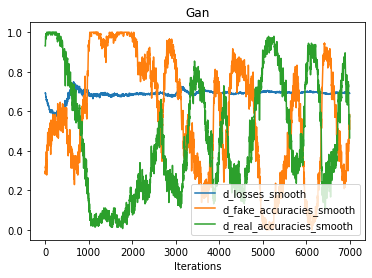

In [14]:
# when to stop: once “good enough” images can be generated, 
# the subjective quality of the images may then begin to vary, improve, or even degrade with subsequent updates.
from typing import List

def plot_metric_general(graphs: List[np.ndarray], labels: List[str]) -> None:
    import matplotlib.pyplot as plt
    epochs = range(1, graphs[0].shape[0] + 1)
    plt.xlabel("Iterations")
    plt.title('Gan')
    for i in range(len(labels)):
        plt.plot(epochs, graphs[i])
    plt.legend(labels)
    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
  
d_losses_smooth, d_fake_accuracies_smooth, d_real_accuracies_smooth = moving_average(d_losses.reshape((epochs)), 9), moving_average(d_fake_accuracies.reshape((epochs)), 9), moving_average(d_real_accuracies.reshape((epochs)), 9)

plot_metric_general([d_losses_smooth, d_fake_accuracies_smooth, d_real_accuracies_smooth], ['d_losses_smooth', 'd_fake_accuracies_smooth', 'd_real_accuracies_smooth'])
# we can see aroud 800 epochs d_fake_accuracies=d_real_accuracies=0.5 and after that it degragates 

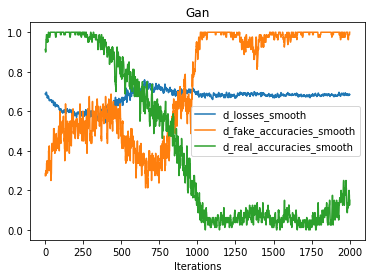

In [15]:
d_losses_smooth, d_fake_accuracies_smooth, d_real_accuracies_smooth = moving_average(d_losses.reshape((epochs)), 5), moving_average(d_fake_accuracies.reshape((epochs)), 5), moving_average(d_real_accuracies.reshape((epochs)), 5)
plot_metric_general([d_losses_smooth[:2000], d_fake_accuracies_smooth[:2000], d_real_accuracies_smooth[:2000]], ['d_losses_smooth', 'd_fake_accuracies_smooth', 'd_real_accuracies_smooth'])
# we can see aroud 800 iteration d_fake_accuracies=d_real_accuracies=0.5 and after that they wobbles one against the other

In [16]:
# import matplotlib.pyplot as plt
# def show_plot(arr):
#   x = range(arr.shape[0])
#   plt.plot(x, arr)

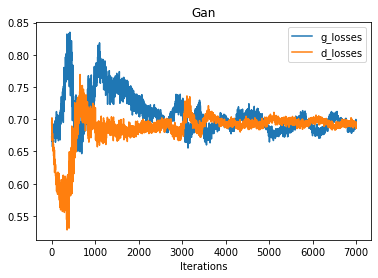

In [17]:
g_losses_smooth, d_losses_smooth = moving_average(g_losses.reshape((epochs)), 3), moving_average(d_losses.reshape((epochs)), 3)
# graph describing the loss of the generator and the discriminator
# models go “back and forth” with their losses, there was no a consistent leader
plot_metric_general([g_losses_smooth, d_losses_smooth], ['g_losses', 'd_losses'])

In [18]:
# show_plot(d_accuracies)

In [19]:
# show_plot(g_accuracies)


In [20]:
# X_train = diab_df.values
# y_real = np.ones((X_train.shape[0], 1))

# # evaluation experiment on diabetes
# print ('real evaluation experiment on all data set')
# _, acc_real = gan.discriminator.evaluate(X_train, y_real, verbose=1)
# y_fake = np.zeros((100, 1))
# noise = np.random.uniform(-1, 1, size=(100, gan.latent_dim))
# x_fake =gan.generator.predict(noise)
# print ('fake evaluation experiment on 100 samples')
# _, acc_facke = gan.discriminator.evaluate(x_fake, y_fake, verbose=1)

real evaluation experiment on all data set
24/24 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.4219
fake evaluation experiment on 100 samples
4/4 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5100


# Evaluate goodness of generated samples 
how to Use basic measures (e.g., Euclidean distance, basic visualization) determine whether the samples that fooled the detector are indeed similar to some of the original data

1- we can calculate the Gausian distribution of each column and check how close it is to real sample distribution

In [ ]:
# gan.generator.save('generator_model_5000.h5')

In [34]:
# we can check for models checkpoints produced good generative samples
loaded_generator = tf.keras.models.load_model('g_model_2600.00_0.70_0.00_0.46_-0.19.h5')
noise = np.random.uniform(-1, 1, size=(100, gan.latent_dim))
x_fake = loaded_generator.predict(noise)
y_fake = np.zeros((100, 1))
# print('x_fake \n', x_fake)
print ('fake loaded_generator evaluation experiment on 100 samples')
_, acc_facke = gan.discriminator.evaluate(x_fake, y_fake, verbose=1)


fake loaded_generator evaluation experiment on 100 samples
4/4 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5900


In [35]:
y_pred_fake = 0
iter1 = 0
while y_pred_fake < 0.5 and iter1 < 100:
  noise = np.random.uniform(-1, 1, size=(1, gan.latent_dim))
  x_fake =loaded_generator(noise)
  y_pred_fake = gan.discriminator.predict(x_fake)[0][0]
  iter1 += 1

y_pred_true = 1
iter2 = 0
while y_pred_true > 0.5 and iter2 < 100:
  noise = np.random.uniform(-1, 1, size=(1, gan.latent_dim))
  x_real =loaded_generator(noise)
  y_pred_true = gan.discriminator.predict(x_real)[0][0]
  iter2 += 1

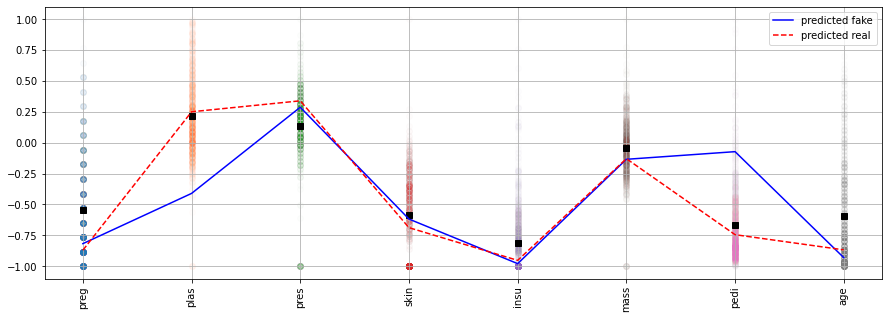

In [38]:
import matplotlib.pyplot as plt
import tensorflow.python.ops.numpy_ops.np_config as np_config
np_config.enable_numpy_behavior()

for col in diab_df:
  xs = [col for x in range(diab_df.shape[0])]
  ys = list(diab_df[col])
  plt.scatter(xs, ys, alpha=0.01)
  plt.plot(col, np.mean(ys) ,'s', c='black', alpha=1, label='_nolegend_')

xs = [x for x in diab_df]
ys = x_fake
plt.plot(xs, ys.tolist()[0], 'b-')

ys = x_real
plt.plot(xs, ys.tolist()[0], 'r--')

plt.legend(["predicted fake", "predicted real"], loc ="upper right")
plt.rcParams['figure.figsize'] = [15, 5]
plt.grid(True)
plt.xticks(rotation=90);

In [ ]:
# sum(diab_df.describe().loc['mean']-np.transpose(x_real).flatten())

-0.7703101979676967